In [3]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict
from fastai import *
from fastai.vision.all import *
from fastai.callback.all import *
import torch.optim as optim
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

In [4]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
    print("GPU Device Name:", torch.cuda.get_device_name(0))  # Assuming you have only one GPU
    print("GPU Compute Capability:", torch.cuda.get_device_capability(0))
    print("Number of GPUs:", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

GPU is available.
GPU Device Name: NVIDIA GeForce RTX 2060
GPU Compute Capability: (7, 5)
Number of GPUs: 1


https://medium.com/@karandeepdps/alexnet-vggnet-resnet-and-inception-11880a1ed3cd

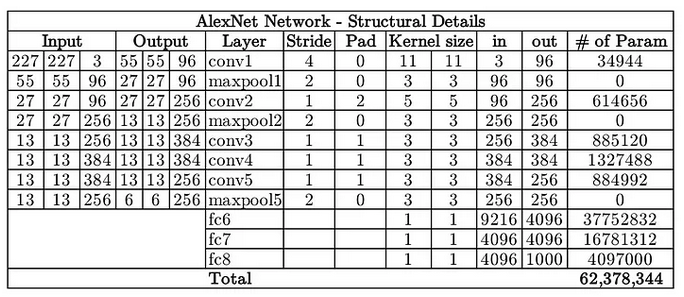

In [5]:

# Set your parameters
lr = 0.01
num_classes = 101 

# Define the classes (assuming you have a file with class names)
classes = open("C:/Users/rsk29/Documents/UT/Fall/AML/Final Project/food-101/meta/classes.txt", 'r').read().splitlines()

# Function to prepare the DataFrame
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    img_path = "C:/Users/rsk29/Documents/UT/Fall/AML/Final Project/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    imgs = []
    for img in array:
        img = img.split('/')
        imgs.append(img)

    imgs = np.array(imgs)
    imgs = pd.DataFrame(imgs[:, 0], imgs[:, 1], columns=['label'])
    imgs['path'] = full_path

    imgs = shuffle(imgs)

    return imgs

# Prepare train and test DataFrames
train_imgs = prep_df("C:/Users/rsk29/Documents/UT/Fall/AML/Final Project/food-101/meta/train.txt")
test_imgs = prep_df("C:/Users/rsk29/Documents/UT/Fall/AML/Final Project/food-101/meta/test.txt")

# Split the training data into train and validation sets (70-30 split)
train_data, val_data = train_test_split(train_imgs, test_size=0.3, random_state=42)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the label encoder class
class LabelEncoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = LabelEncoder(classes)

# Define the dataset class
class FoodLabelsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and loaders for train, validation, and test sets
train_dataset = FoodLabelsDataset(train_data, transform=transform)
val_dataset = FoodLabelsDataset(val_data, transform=transform)
test_dataset = FoodLabelsDataset(test_imgs, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Use the pre-trained AlexNet model
model_alexnet = models.alexnet(pretrained=True)
# Change the output layer to match the number of classes
model_alexnet.classifier[6] = nn.Linear(4096, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_alexnet = optim.SGD(model_alexnet.parameters(), lr=0.01, momentum=0.9)

# Move the AlexNet model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_alexnet.to(device)

# Training loop for AlexNet
num_epochs = 10
columns = ['Epoch', 'Batch', 'Phase', 'Loss', 'Accuracy']
results_df_alexnet = pd.DataFrame(columns=columns)

for epoch in range(num_epochs):
    for phase in ['Train', 'Validation']:
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        data_loader = train_loader if phase == 'Train' else val_loader

        model_alexnet.train() if phase == 'Train' else model_alexnet.eval()

        with torch.set_grad_enabled(phase == 'Train'):
            for i, data in enumerate(tqdm(data_loader, desc=f'{phase} Epoch {epoch + 1}/{num_epochs}', unit='batch')):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer_alexnet.zero_grad()

                outputs = model_alexnet(inputs)
                loss = criterion(outputs, labels)

                if phase == 'Train':
                    loss.backward()
                    optimizer_alexnet.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                if i % 100 == 99:  # Print every 100 mini-batches
                    avg_loss = running_loss / 100
                    accuracy = correct_predictions / total_samples * 100
                    print(f"[{epoch + 1}, {i + 1:5d}] {phase} loss: {avg_loss:.3f}, accuracy: {accuracy:.2f}%")

                    # Append results to the DataFrame
                    results_df_alexnet = pd.concat([results_df_alexnet, pd.DataFrame({
                        'Epoch': epoch + 1,
                        'Batch': i + 1,
                        'Phase': phase,
                        'Loss': avg_loss,
                        'Accuracy': accuracy
                    }, index=[0])], ignore_index=True)
                    running_loss = 0.0
                    correct_predictions = 0
                    total_samples = 0

# Save the trained AlexNet model with validation
torch.save(model_alexnet.state_dict(), 'trained_model_alexnet_with_validation.pth')
print("Model saved successfully")

# Save the training and validation results to a CSV file
results_df_alexnet.to_csv('training_validation_results_alexnet.csv', index=False)



C:\Users\rsk29\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rsk29\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Epoch 1/10:  24%|██████████████▏                                            | 100/415 [01:21<04:54,  1.07batch/s]

[1,   100] Train loss: 3.500, accuracy: 19.47%


Train Epoch 1/10:  48%|████████████████████████████▍                              | 200/415 [02:45<02:51,  1.25batch/s]

[1,   200] Train loss: 2.937, accuracy: 29.51%


Train Epoch 1/10:  72%|██████████████████████████████████████████▋                | 300/415 [04:08<01:37,  1.17batch/s]

[1,   300] Train loss: 2.776, accuracy: 32.94%


Train Epoch 1/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:28<00:11,  1.35batch/s]

[1,   400] Train loss: 2.661, accuracy: 34.77%


Validation Epoch 1/10:  56%|██████████████████████████████▎                       | 100/178 [01:13<00:58,  1.34batch/s]

[1,   100] Validation loss: 2.674, accuracy: 34.67%


Train Epoch 2/10:  24%|██████████████▏                                            | 100/415 [01:11<03:46,  1.39batch/s]

[2,   100] Train loss: 2.343, accuracy: 41.23%


Train Epoch 2/10:  48%|████████████████████████████▍                              | 200/415 [02:28<02:50,  1.26batch/s]

[2,   200] Train loss: 2.349, accuracy: 41.00%


Train Epoch 2/10:  72%|██████████████████████████████████████████▋                | 300/415 [03:49<01:33,  1.23batch/s]

[2,   300] Train loss: 2.311, accuracy: 41.84%


Train Epoch 2/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:10<00:11,  1.26batch/s]

[2,   400] Train loss: 2.243, accuracy: 43.29%


Validation Epoch 2/10:  56%|██████████████████████████████▎                       | 100/178 [01:19<00:56,  1.37batch/s]

[2,   100] Validation loss: 2.309, accuracy: 42.45%


Train Epoch 3/10:  24%|██████████████▏                                            | 100/415 [01:13<03:46,  1.39batch/s]

[3,   100] Train loss: 1.971, accuracy: 49.13%


Train Epoch 3/10:  48%|████████████████████████████▍                              | 200/415 [02:26<02:36,  1.37batch/s]

[3,   200] Train loss: 2.011, accuracy: 47.92%


Train Epoch 3/10:  72%|██████████████████████████████████████████▋                | 300/415 [03:40<01:24,  1.36batch/s]

[3,   300] Train loss: 1.999, accuracy: 48.91%


Train Epoch 3/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:00<00:11,  1.27batch/s]

[3,   400] Train loss: 2.048, accuracy: 47.54%


Validation Epoch 3/10:  56%|██████████████████████████████▎                       | 100/178 [01:18<01:02,  1.26batch/s]

[3,   100] Validation loss: 2.137, accuracy: 46.30%


Train Epoch 4/10:  24%|██████████████▏                                            | 100/415 [01:16<03:50,  1.37batch/s]

[4,   100] Train loss: 1.683, accuracy: 55.41%


Train Epoch 4/10:  48%|████████████████████████████▍                              | 200/415 [02:36<02:48,  1.28batch/s]

[4,   200] Train loss: 1.742, accuracy: 54.42%


Train Epoch 4/10:  72%|██████████████████████████████████████████▋                | 300/415 [03:54<01:26,  1.32batch/s]

[4,   300] Train loss: 1.798, accuracy: 52.98%


Train Epoch 4/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:10<00:11,  1.35batch/s]

[4,   400] Train loss: 1.795, accuracy: 53.00%


Validation Epoch 4/10:  56%|██████████████████████████████▎                       | 100/178 [01:18<01:00,  1.30batch/s]

[4,   100] Validation loss: 2.122, accuracy: 47.20%


Train Epoch 5/10:  24%|██████████████▏                                            | 100/415 [01:25<03:51,  1.36batch/s]

[5,   100] Train loss: 1.477, accuracy: 59.84%


Train Epoch 5/10:  48%|████████████████████████████▍                              | 200/415 [02:44<03:04,  1.17batch/s]

[5,   200] Train loss: 1.521, accuracy: 59.05%


Train Epoch 5/10:  72%|██████████████████████████████████████████▋                | 300/415 [04:11<01:46,  1.08batch/s]

[5,   300] Train loss: 1.547, accuracy: 58.51%


Train Epoch 5/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:38<00:14,  1.03batch/s]

[5,   400] Train loss: 1.569, accuracy: 58.19%


Validation Epoch 5/10:  56%|██████████████████████████████▎                       | 100/178 [01:31<01:07,  1.16batch/s]

[5,   100] Validation loss: 2.168, accuracy: 46.48%


Train Epoch 6/10:  24%|██████████████▏                                            | 100/415 [01:22<04:05,  1.28batch/s]

[6,   100] Train loss: 1.239, accuracy: 65.57%


Train Epoch 6/10:  48%|████████████████████████████▍                              | 200/415 [02:35<02:38,  1.36batch/s]

[6,   200] Train loss: 1.348, accuracy: 63.30%


Train Epoch 6/10:  72%|██████████████████████████████████████████▋                | 300/415 [03:50<01:25,  1.34batch/s]

[6,   300] Train loss: 1.396, accuracy: 61.95%


Train Epoch 6/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:04<00:11,  1.36batch/s]

[6,   400] Train loss: 1.441, accuracy: 60.74%


Validation Epoch 6/10:  56%|██████████████████████████████▎                       | 100/178 [01:14<01:02,  1.25batch/s]

[6,   100] Validation loss: 2.225, accuracy: 46.88%


Train Epoch 7/10:  24%|██████████████▏                                            | 100/415 [01:21<04:20,  1.21batch/s]

[7,   100] Train loss: 1.089, accuracy: 68.70%


Train Epoch 7/10:  48%|████████████████████████████▍                              | 200/415 [02:43<02:51,  1.26batch/s]

[7,   200] Train loss: 1.167, accuracy: 67.21%


Train Epoch 7/10:  72%|██████████████████████████████████████████▋                | 300/415 [03:59<01:26,  1.33batch/s]

[7,   300] Train loss: 1.186, accuracy: 66.88%


Train Epoch 7/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:16<00:11,  1.29batch/s]

[7,   400] Train loss: 1.259, accuracy: 64.83%


Validation Epoch 7/10:  56%|██████████████████████████████▎                       | 100/178 [01:15<00:59,  1.31batch/s]

[7,   100] Validation loss: 2.260, accuracy: 46.26%


Train Epoch 8/10:  24%|██████████████▏                                            | 100/415 [01:15<04:24,  1.19batch/s]

[8,   100] Train loss: 0.970, accuracy: 71.93%


Train Epoch 8/10:  48%|████████████████████████████▍                              | 200/415 [02:32<02:44,  1.31batch/s]

[8,   200] Train loss: 1.010, accuracy: 71.30%


Train Epoch 8/10:  72%|██████████████████████████████████████████▋                | 300/415 [03:50<01:35,  1.20batch/s]

[8,   300] Train loss: 1.081, accuracy: 69.78%


Train Epoch 8/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:11<00:11,  1.36batch/s]

[8,   400] Train loss: 1.150, accuracy: 67.27%


Validation Epoch 8/10:  56%|██████████████████████████████▎                       | 100/178 [01:15<00:57,  1.35batch/s]

[8,   100] Validation loss: 2.227, accuracy: 47.72%


Train Epoch 9/10:  24%|██████████████▏                                            | 100/415 [01:16<03:57,  1.33batch/s]

[9,   100] Train loss: 0.837, accuracy: 75.84%


Train Epoch 9/10:  48%|████████████████████████████▍                              | 200/415 [02:33<02:47,  1.29batch/s]

[9,   200] Train loss: 0.900, accuracy: 73.84%


Train Epoch 9/10:  72%|██████████████████████████████████████████▋                | 300/415 [03:50<01:29,  1.29batch/s]

[9,   300] Train loss: 1.009, accuracy: 71.12%


Train Epoch 9/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [05:07<00:11,  1.32batch/s]

[9,   400] Train loss: 1.068, accuracy: 69.62%


Validation Epoch 9/10:  56%|██████████████████████████████▎                       | 100/178 [01:15<00:58,  1.33batch/s]

[9,   100] Validation loss: 2.322, accuracy: 47.67%


Train Epoch 10/10:  24%|█████████████▉                                            | 100/415 [01:15<04:12,  1.25batch/s]

[10,   100] Train loss: 0.761, accuracy: 77.74%


Train Epoch 10/10:  48%|███████████████████████████▉                              | 200/415 [02:30<02:38,  1.36batch/s]

[10,   200] Train loss: 0.842, accuracy: 75.09%


Train Epoch 10/10:  72%|█████████████████████████████████████████▉                | 300/415 [03:45<01:24,  1.36batch/s]

[10,   300] Train loss: 0.894, accuracy: 73.88%


Train Epoch 10/10:  96%|███████████████████████████████████████████████████████▉  | 400/415 [05:03<00:12,  1.23batch/s]

[10,   400] Train loss: 0.948, accuracy: 72.89%


Validation Epoch 10/10:  56%|█████████████████████████████▊                       | 100/178 [01:16<00:57,  1.36batch/s]

[10,   100] Validation loss: 2.443, accuracy: 47.45%


Validation Epoch 10/10: 100%|█████████████████████████████████████████████████████| 178/178 [02:10<00:00,  1.36batch/s]


Model saved successfully


In [6]:
# Evaluate the AlexNet model on the test set
model_alexnet.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing', unit='batch'):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_alexnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate test accuracy for AlexNet
test_accuracy_alexnet = correct_predictions / total_samples * 100
print(f'Test Accuracy (AlexNet): {test_accuracy_alexnet:.2f}%')


Testing: 100%|████████████████████████████████████████████████████████████████████| 198/198 [02:17<00:00,  1.44batch/s]

Test Accuracy (AlexNet): 52.74%


Testing: 100%|████████████████████████████████████████████████████████████████████| 198/198 [02:32<00:00,  1.29batch/s]


Correctly Classified Examples (AlexNet):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

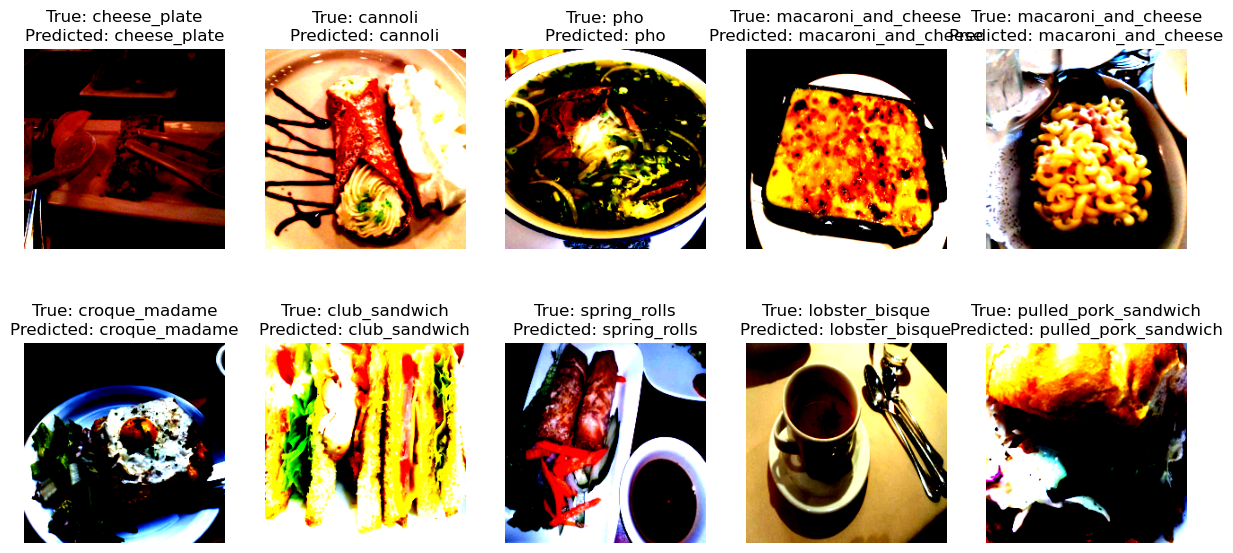

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Incorrectly Classified Examples (AlexNet):


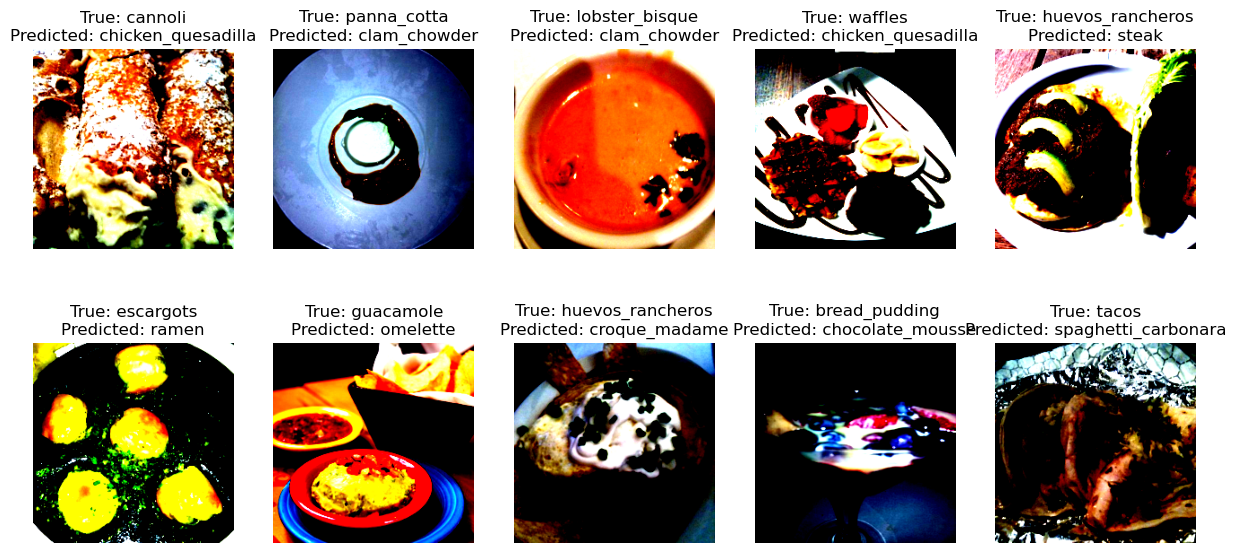

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set the AlexNet model to evaluation mode
model_alexnet.eval()

# Lists to store correct and incorrect predictions
correctly_classified_alexnet = []
incorrectly_classified_alexnet = []

with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing', unit='batch'):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_alexnet(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Convert to numpy arrays
        inputs_cpu = inputs.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        # Iterate through batch
        for i in range(len(predicted_cpu)):
            image = np.transpose(inputs_cpu[i], (1, 2, 0))
            true_label = encoder.get_label(labels_cpu[i])
            predicted_label = encoder.get_label(predicted_cpu[i])

            if predicted_cpu[i] == labels_cpu[i]:
                correctly_classified_alexnet.append((image, true_label, predicted_label))
            else:
                incorrectly_classified_alexnet.append((image, true_label, predicted_label))

# Display correctly classified examples for AlexNet
print("Correctly Classified Examples (AlexNet):")
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i, (image, true_label, predicted_label) in enumerate(correctly_classified_alexnet[:10]):
    axes[i // 5, i % 5].imshow(image)
    axes[i // 5, i % 5].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    axes[i // 5, i % 5].axis('off')

plt.show()

# Display incorrectly classified examples for AlexNet
print("Incorrectly Classified Examples (AlexNet):")
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i, (image, true_label, predicted_label) in enumerate(incorrectly_classified_alexnet[:10]):
    axes[i // 5, i % 5].imshow(image)
    axes[i // 5, i % 5].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    axes[i // 5, i % 5].axis('off')

plt.show()


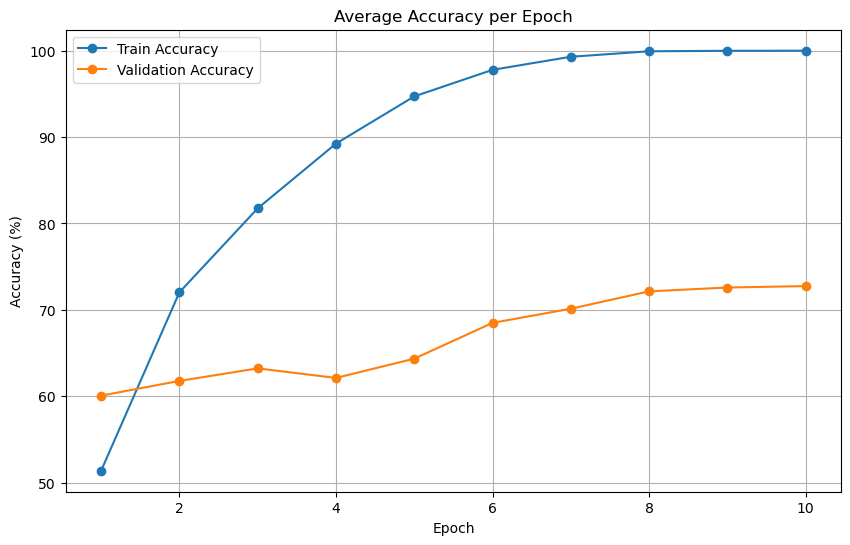

In [39]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'Epoch' and calculate the mean accuracy for each group
avg_accuracy_df_alexnet = results_df_alexnet.groupby(['Epoch', 'Phase'])['Accuracy'].mean().reset_index()

# Separate train and validation data for AlexNet
train_data_alexnet = avg_accuracy_df_alexnet[avg_accuracy_df_alexnet['Phase'] == 'Train']
val_data_alexnet = avg_accuracy_df_alexnet[avg_accuracy_df_alexnet['Phase'] == 'Validation']

# Plot the line chart for AlexNet
plt.figure(figsize=(10, 6))
plt.plot(train_data_alexnet['Epoch'], train_data_alexnet['Accuracy'], label='Train Accuracy (AlexNet)', marker='o')
plt.plot(val_data_alexnet['Epoch'], val_data_alexnet['Accuracy'], label='Validation Accuracy (AlexNet)', marker='o')
plt.title('Average Accuracy per Epoch (AlexNet)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


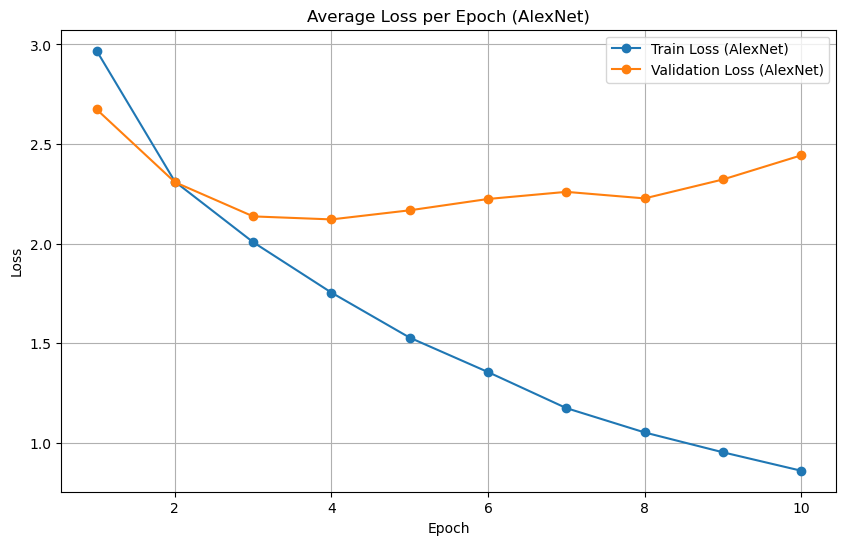

In [8]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'Epoch' and calculate the mean loss for each group
avg_loss_df_alexnet = results_df_alexnet.groupby(['Epoch', 'Phase'])['Loss'].mean().reset_index()

# Separate train and validation data for AlexNet
train_data_loss_alexnet = avg_loss_df_alexnet[avg_loss_df_alexnet['Phase'] == 'Train']
val_data_loss_alexnet = avg_loss_df_alexnet[avg_loss_df_alexnet['Phase'] == 'Validation']

# Plot the line chart for loss with AlexNet
plt.figure(figsize=(10, 6))
plt.plot(train_data_loss_alexnet['Epoch'], train_data_loss_alexnet['Loss'], label='Train Loss (AlexNet)', marker='o')
plt.plot(val_data_loss_alexnet['Epoch'], val_data_loss_alexnet['Loss'], label='Validation Loss (AlexNet)', marker='o')
plt.title('Average Loss per Epoch (AlexNet)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Set the AlexNet model to evaluation mode
model_alexnet.eval()

# Lists to store true and predicted labels for AlexNet
true_labels_alexnet = []
predicted_labels_alexnet = []

with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing', unit='batch'):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_alexnet(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Convert to numpy arrays
        true_labels_alexnet.extend(labels.cpu().numpy())
        predicted_labels_alexnet.extend(predicted.cpu().numpy())

# Calculate the confusion matrix for AlexNet
cm_alexnet = confusion_matrix(true_labels_alexnet, predicted_labels_alexnet)

# Create a DataFrame from the confusion matrix for AlexNet
confusion_matrix_df_alexnet = pd.DataFrame(cm_alexnet, index=classes, columns=classes)

# Add columns for correctly and incorrectly classified counts for AlexNet
confusion_matrix_df_alexnet['Correctly Classified'] = np.diag(cm_alexnet)
confusion_matrix_df_alexnet['Incorrectly Classified'] = 250 - np.diag(cm_alexnet)

# Save the DataFrame to a CSV file for AlexNet
confusion_matrix_df_alexnet.to_csv('confusion_matrix_with_counts_alexnet.csv')

# Calculate the percentage of correct classification for AlexNet
confusion_matrix_df_alexnet['% Correct Classification'] = (confusion_matrix_df_alexnet['Correctly Classified'] / 250) * 100

# Save the DataFrame to a CSV file for AlexNet
confusion_matrix_df_alexnet.to_csv('confusion_matrix_with_percentages_alexnet.csv')

# Sort the DataFrame based on the % Correct Classification column in descending order for AlexNet
confusion_matrix_df_sorted_alexnet = confusion_matrix_df_alexnet.sort_values(by='% Correct Classification', ascending=False)

# Display the DataFrame for AlexNet
confusion_matrix_df_sorted_alexnet


Testing: 100%|████████████████████████████████████████████████████████████████████| 198/198 [02:16<00:00,  1.45batch/s]


,apple_pie,baby_back_ribs,baklava,beef_carpaccio,beef_tartare,beet_salad,beignets,bibimbap,bread_pudding,breakfast_burrito,...,strawberry_shortcake,sushi,tacos,takoyaki,tiramisu,tuna_tartare,waffles,Correctly Classified,Incorrectly Classified,% Correct Classification
gnocchi,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,232,18,92.8
nachos,0,1,0,0,0,1,2,0,0,0,...,0,0,0,0,1,0,0,226,24,90.4
crab_cakes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,215,35,86.0
tuna_tartare,0,0,2,1,1,1,1,0,0,0,...,0,0,0,1,0,207,0,207,43,82.8
caesar_salad,0,3,0,0,3,0,0,0,1,0,...,0,0,1,1,0,3,0,201,49,80.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
escargots,0,11,0,3,0,1,0,0,4,1,...,1,3,0,1,0,0,2,59,191,23.6
guacamole,1,1,2,0,2,0,0,0,4,0,...,4,13,2,0,0,2,1,59,191,23.6
bibimbap,1,0,1,2,0,0,0,59,1,4,...,0,0,1,0,0,0,1,59,191,23.6
risotto,0,1,0,7,0,5,2,37,0,3,...,0,0,0,0,0,0,0,55,195,22.0
